## CRF for Aspect Tagger

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [17]:
from lxml import etree

from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV
from sklearn import cross_validation

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [31]:
# read ReLi trainset
trainset = list()
xmldoc = etree.parse('../corpus/SemEvalABSA2015EnglishRestaurants_train.xml')

for sentence_node in xmldoc.iter('sentence'):
    sentence = list()
    for word_node in sentence_node.iter('word'):
        tag = 'O'
        if word_node.get('opinion') == 'true':
            tag = 'OBJ'
        sentence.append({
                'id': word_node.get('id'),
                'form': word_node.get('form'),
                'base': word_node.get('form'),
                'postag': word_node.get('postag'),                
                'head': word_node.get('head'),
                'deprel': word_node.get('deprel'),                
                'from': word_node.get('from'),
                'to': word_node.get('to'),
                'tag': tag})
    if len(sentence) != 0:
        trainset.append(sentence)

In [32]:
# read ReLi testset
testset = list()
xmldoc = etree.parse('../corpus/SemEvalABSA2015EnglishRestaurants_test.xml')

for sentence_node in xmldoc.iter('sentence'):
    sentence = list()
    for word_node in sentence_node.iter('word'):
        tag = 'O'
        if word_node.get('opinion') == 'true':
            tag = 'OBJ'
        sentence.append({
                'id': word_node.get('id'),
                'form': word_node.get('form'),
                'base': word_node.get('form'),
                'postag': word_node.get('postag'),                
                'head': word_node.get('head'),
                'deprel': word_node.get('deprel'),                
                'from': word_node.get('from'),
                'to': word_node.get('to'),
                'tag': tag})
    if len(sentence) != 0:
        testset.append(sentence)

In [33]:
# change head number by the token under that position
for sentence in trainset:
    for index, word in enumerate(sentence):
        try:
            sentence[index]['dep'] = sentence[int(word['head']) - 1]['form'].lower()
        except:
            sentence[index]['dep'] = 'ROOT'
            
# change head number by the token under that position
for sentence in testset:
    for index, word in enumerate(sentence):        
        try:
            sentence[index]['dep'] = sentence[int(word['head']) - 1]['form'].lower()
        except:
            sentence[index]['dep'] = 'ROOT'

In [34]:
trainset[0]

[{'base': 'Judging',
  'dep': '.',
  'deprel': 'root',
  'form': 'Judging',
  'from': '0',
  'head': '0',
  'id': '1',
  'postag': 'VBG',
  'tag': 'O',
  'to': '7'},
 {'base': 'from',
  'dep': 'posts',
  'deprel': 'case',
  'form': 'from',
  'from': '8',
  'head': '4',
  'id': '2',
  'postag': 'IN',
  'tag': 'O',
  'to': '12'},
 {'base': 'previous',
  'dep': 'posts',
  'deprel': 'amod',
  'form': 'previous',
  'from': '13',
  'head': '4',
  'id': '3',
  'postag': 'JJ',
  'tag': 'O',
  'to': '21'},
 {'base': 'posts',
  'dep': 'judging',
  'deprel': 'nmod',
  'form': 'posts',
  'from': '22',
  'head': '1',
  'id': '4',
  'postag': 'NNS',
  'tag': 'O',
  'to': '27'},
 {'base': 'this',
  'dep': 'used',
  'deprel': 'nsubj',
  'form': 'this',
  'from': '28',
  'head': '6',
  'id': '5',
  'postag': 'DT',
  'tag': 'O',
  'to': '32'},
 {'base': 'used',
  'dep': 'judging',
  'deprel': 'ccomp',
  'form': 'used',
  'from': '33',
  'head': '1',
  'id': '6',
  'postag': 'VBN',
  'tag': 'O',
  'to': 

In [35]:
testset[0]

[{'base': 'Love',
  'dep': 'la',
  'deprel': 'compound',
  'form': 'Love',
  'from': '0',
  'head': '4',
  'id': '1',
  'postag': 'NNP',
  'tag': 'O',
  'to': '4'},
 {'base': 'Al',
  'dep': 'la',
  'deprel': 'compound',
  'form': 'Al',
  'from': '5',
  'head': '4',
  'id': '2',
  'postag': 'NNP',
  'tag': 'OBJ',
  'to': '7'},
 {'base': 'Di',
  'dep': 'la',
  'deprel': 'compound',
  'form': 'Di',
  'from': '8',
  'head': '4',
  'id': '3',
  'postag': 'NNP',
  'tag': 'OBJ',
  'to': '10'},
 {'base': 'La',
  'dep': 'la',
  'deprel': 'root',
  'form': 'La',
  'from': '11',
  'head': '0',
  'id': '4',
  'postag': 'NNP',
  'tag': 'OBJ',
  'to': '13'}]

In [36]:
def extract_features(dataset):
    features_list = []
    for sent in dataset:
        sentence_features = []
        for i in range(len(sent)):
                                
            word = sent[i]['form']
            postag = sent[i]['postag']
            dep = sent[i]['dep']            

            features = {
                'bias': 1.0,
                'word.lower()': word.lower(),
                'postag': postag,
                'dep': dep,                
            }
            if i > 0:
                word1 = sent[i-1]['form']
                postag1 = sent[i-1]['postag']
                dep1 = sent[i-1]['dep']                
                features.update({
                    '-1:word.lower()': word1.lower(),
                    '-1:postag': postag1,
                    '-1:dep1': dep1,                                            
                })
            else:
                features['BOS'] = True

            if i < len(sent)-1:
                word1 = sent[i+1]['base']
                postag1 = sent[i+1]['postag']
                dep1 = sent[i+1]['dep']                
                features.update({
                    '+1:word.lower()': word1.lower(),                    
                    '+1:postag': postag1,
                    '+1:dep1': dep1,                    
                })
            else:
                features['EOS'] = True
            sentence_features.append(features)
        features_list.append(sentence_features)
    return features_list

In [37]:
def extract_labels(dataset):
    labels = []
    for sentence in dataset:
        sentence_labels = []
        for word in sentence:            
            sentence_labels.append(word['tag'])
        labels.append(sentence_labels)
    return labels

In [38]:
X_train = extract_features(trainset)
y_train = extract_labels(trainset)

In [39]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 1.04 s, sys: 0 ns, total: 1.04 s
Wall time: 1.04 s


In [40]:
X_test = extract_features(testset)
y_test = extract_labels(testset)

In [41]:
labels = list(crf.classes_)
y_pred = crf.predict(X_test)

In [42]:
metrics.flat_f1_score(y_test, y_pred, average='binary', labels=labels, pos_label='OBJ')

0.61617647058823533

In [43]:
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

             precision    recall  f1-score   support

          O      0.961     0.986     0.973      9626
        OBJ      0.758     0.519     0.616       807

avg / total      0.945     0.950     0.946     10433



## Leave one out evaluation

In [30]:
data = extract_features(testset)
target = extract_labels(testset)

clf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)

# leave-one-out
predicted = cross_validation.cross_val_predict(clf, data, target, cv=len(target))

In [ ]:
metrics.flat_f1_score(target, predicted, average='binary', labels=labels, pos_label='OBJ')

In [ ]:
print(metrics.flat_classification_report(
    target, predicted, labels=labels, digits=3
))

## Tunning parameters

In [35]:
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='binary', labels=labels, pos_label='OBJ')

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=None, c2=None,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error...e,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f87b4d231d0>, 'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f87b4ce0c18>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=make_scorer(flat_f1_score, pos_label=OBJ, average=binary, labels=['O', 'OBJ']),
          verbose=1)

In [36]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c2': 0.010198203357456906, 'c1': 0.005434272686108428}
best CV score: 0.22123039725
model size: 0.62M


Dark blue => 0.09457, dark red => 0.2212


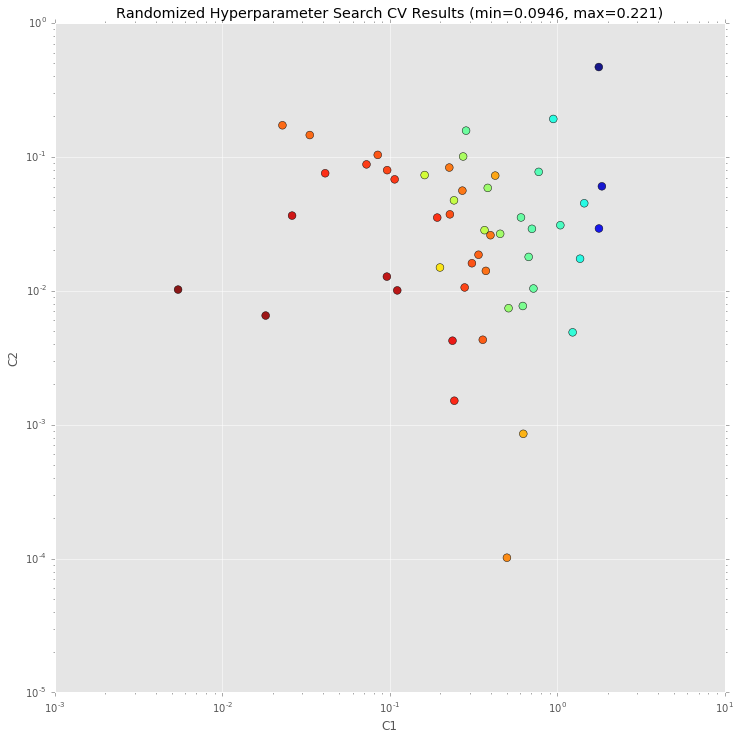

In [39]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [44]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

             precision    recall  f1-score   support

          O      0.981     0.995     0.988     59150
        OBJ      0.363     0.125     0.186      1271

avg / total      0.968     0.977     0.971     60421



## Statistics

In [117]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
O      -> O       1.618999
OBJ    -> OBJ     0.646499
O      -> OBJ     -1.584553
OBJ    -> O       -2.540803

Top unlikely transitions:
O      -> O       1.618999
OBJ    -> OBJ     0.646499
O      -> OBJ     -1.584553
OBJ    -> O       -2.540803


In [118]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
4.284822 OBJ      -1:word.lower():xd
4.113073 OBJ      -1:word.lower():su-real
3.591978 O        +1:word.lower():historia
3.441271 OBJ      word.lower():historia
3.234007 OBJ      -1:word.lower():seis-
3.193690 OBJ      dep:interrompi
3.172837 OBJ      -1:word.lower():ler_ensaio
3.158312 OBJ      -1:word.lower():explicito
3.129039 OBJ      -1:dep1:amadureçe
3.070519 OBJ      +1:dep1:bestas
2.939679 OBJ      -1:word.lower():acuca
2.904968 OBJ      dep:variação
2.890807 OBJ      -1:word.lower():bênção
2.876006 O        dep:1984
2.864030 OBJ      +1:dep1:esperadas
2.823446 O        -1:word.lower():edward_cullen
2.805666 O        -1:word.lower():jeff_stevens
2.795340 OBJ      word.lower():narrativa
2.756331 O        -1:word.lower():principal
2.750563 OBJ      word.lower():liro
2.728642 OBJ      -1:word.lower():lisa_jane_smith
2.694669 OBJ      word.lower():³
2.694669 OBJ      dep:recomendo³
2.691311 O        -1:word.lower():enredo
2.685302 OBJ      -1:word.lower():cubo
2.6658